In [13]:
#安装依赖
#!pip install cvxopt

In [14]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from matplotlib import pyplot as plt

# 这里改成自己本地数据包的位置
PERFIX = './fin_data/'

def get_return(ticker):
    tmp_lst = []
    fname = PERFIX + 'data_'+ticker+'.csv'
    with open(fname, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            tmp_lst.append(row)
    df = pd.DataFrame(tmp_lst[1:], columns=tmp_lst[0]) 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    #print(df)
    temp = df['Close'].astype('float64').pct_change().fillna(0.)
    return temp;



secIDs = ['000300.ZICN','000905.ZICN','399006.ZICN','SPX.ZIUS','000012.ZICN','000013.ZICN']   
rtn_table = DataFrame()

for secID in secIDs:
    cp = get_return(secID)
    cp.name = secID
    rtn_table = pd.concat([rtn_table,cp],axis=1)
    
rtn_table.fillna(0,inplace = True)

#rtn_table.head(5)


#rtn_table.mean()*250

#rtn_table.corr()

In [15]:
rtn_table.mean() * 250

000300.ZICN    0.157442
000905.ZICN    0.187176
399006.ZICN    0.272201
SPX.ZIUS       0.159705
000012.ZICN    0.032997
000013.ZICN    0.063872
dtype: float64

In [16]:
rtn_table.std() * np.sqrt(250)

000300.ZICN    0.198318
000905.ZICN    0.215463
399006.ZICN    0.272113
SPX.ZIUS       0.114754
000012.ZICN    0.006488
000013.ZICN    0.006563
dtype: float64

In [17]:
rtn_table.corr()

,000300.ZICN,000905.ZICN,399006.ZICN,SPX.ZIUS,000012.ZICN,000013.ZICN
000300.ZICN,1.000000,0.835425,0.570435,0.062453,-0.030545,0.074581
000905.ZICN,0.835425,1.000000,0.834699,0.042655,-0.012397,0.131355
399006.ZICN,0.570435,0.834699,1.000000,0.021552,-0.050975,0.120189
SPX.ZIUS,0.062453,0.042655,0.021552,1.000000,0.000327,0.034943
000012.ZICN,-0.030545,-0.012397,-0.050975,0.000327,1.000000,0.187268
000013.ZICN,0.074581,0.131355,0.120189,0.034943,0.187268,1.000000


In [18]:
from cvxopt import matrix,solvers

portfolio1 = [0,1,2,4,5] 
portfolio2 = range(6)
cov_mat = rtn_table.cov() * 250
exp_rtn = rtn_table.mean() * 250

def cal_efficient_frontier(portfolio):

    if len(portfolio) <=2 or len(portfolio) > 6: 
        raise Exception('portfolio必须为长度大于2小于7的list！')
    #print(cov_mat)
    cov_mat1 = cov_mat.iloc[portfolio,portfolio]
    exp_rtn1 = exp_rtn.iloc[portfolio]
    max_rtn = max(exp_rtn1)
    min_rtn = min(exp_rtn1)
    risks = []
    returns = []

    for level_rtn in np.linspace(min_rtn, max_rtn, 20):
        sec_num = len(portfolio)
        P = 2 * matrix(cov_mat1.values)
        q = matrix(np.zeros(sec_num))
        G = matrix(np.diag(-1 * np.ones(sec_num)))
        h = matrix(0.0, (sec_num,1))
        A = matrix(np.matrix([np.ones(sec_num),exp_rtn1.values]))
        b = matrix([1.0,level_rtn])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P,q, G, h, A, b)
        risks.append(sol['primal objective'])
        returns.append(level_rtn)
    return np.sqrt(risks), returns


risk1, return1 = cal_efficient_frontier(portfolio1)
risk2, return2 = cal_efficient_frontier(portfolio2)

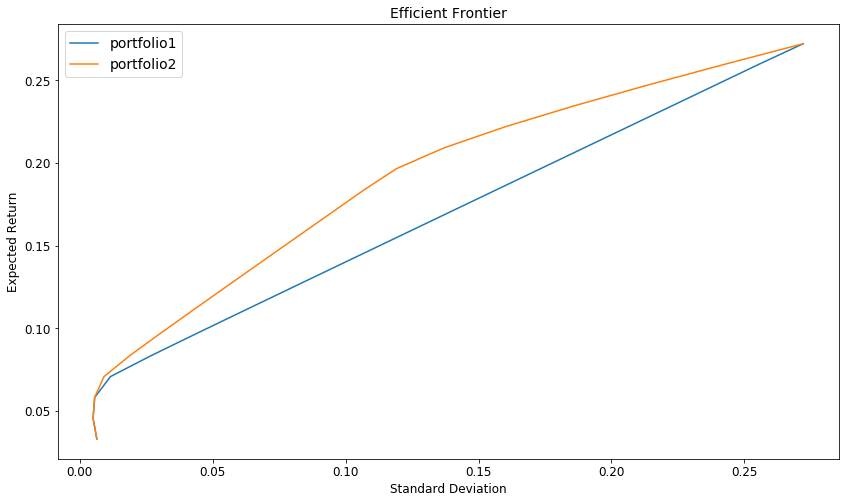

In [19]:
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.plot(risk1,return1)
ax1.plot(risk2,return2) 
ax1.set_title('Efficient Frontier', fontsize = 14)
ax1.set_xlabel('Standard Deviation', fontsize = 12)
ax1.set_ylabel('Expected Return', fontsize = 12)
ax1.tick_params(labelsize = 12)
ax1.legend(['portfolio1','portfolio2'], loc = 'best', fontsize = 14)

In [20]:
risk_aversion = 3
P = risk_aversion * matrix(cov_mat.values)
q = -1 * matrix(exp_rtn.values)
G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))),np.diag(-np.ones(len(exp_rtn))))))
h = matrix(np.array([np.ones(len(exp_rtn)),np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))
A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
b = matrix([1.0])
solvers.options['show_progress'] = False
sol = solvers.qp(P,q, G, h, A, b)
DataFrame(index=exp_rtn.index,data = np.round(sol['x'],2), columns = ['weight'])  # 权重精确到小数点后两位



,weight
000300.ZICN,0.00
000905.ZICN,0.00
399006.ZICN,0.58
SPX.ZIUS,0.42
000012.ZICN,0.00
000013.ZICN,0.00


In [21]:
print('执行完毕!')

执行完毕!


## TODO 目前缺少调仓python程序代码
def xxx(*args):
    pass